Install necessary dependencies

In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.6 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [2]:
!pip install openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.8 MB/s eta 0:00:00


Import Necessary Libraries

In [3]:
from datasets import load_dataset
import pandas as pd
from openai import OpenAI
import os
import json
import matplotlib.pyplot as plt
import numpy as np

Load Dataset from HuggingFace

In [4]:
dataset_clean = load_dataset("cmudrc/Material_Selection_Eval", "clean_responses")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/67 [00:00<?, ? examples/s]

In [5]:
dataset_clean_pd = dataset_clean['train'].to_pandas()

In [6]:
directory = 'data/csv_files'

if not os.path.exists(directory):
    os.makedirs(directory)

In [7]:
file_path = os.path.join(directory, 'clean_responses.csv')

Save CSV file for comparison

In [8]:
dataset_clean_pd.to_csv(file_path, index=False)

Create a simple completion using OpenAI Completion API

In [9]:
from google.colab import userdata
openAI_key = userdata.get('openai_key')

In [10]:
client = OpenAI(api_key=openAI_key)

def get_completion(prompt, model="gpt-4o"):
    messages = [{"role": "user", "content": prompt}
                ,{"role": "system", "content": "You are a Materials Science and Design Engineering expert."}]
    response = client.chat.completions.create(
        model=model,
        messages=messages,
        temperature=0,
        response_format={"type": "json_object"}
    )
    return response.choices[0].message.content


Define data for loops

In [11]:
material_families = f'''
1. Steel
2. Aluminium
3. Titanium
4. Glass
5. Wood
6. Thermoplastic
7. Elastomer
8. Thermoset
9. Composite
'''

design_choice = [
    "Kitchen Utensil Grip",
    "Spacecraft Component",
    "Underwater Component",
    "Safety Helmet"
]

criterion = [
    "Lightweight",
    "Resistant to Heat",
    "Corrosion Resistant",
    "High Strength"
]


Prompt for generating scores of design choices

In [12]:
def prompt_response(design_choice: str, criterion: str):
    prompt = f"""
    You are given a problem statement to assist a designer as below:
    The information below is provided to you delimited by triple backticks

    Design: '''{design_choice}'''
    Criterion: '''{criterion}'''

    You are tasked with designing the grip of {design_choice} which should be {criterion}.

    How well do you think each of the provided materials would perform in this application?

    As a materials science and design engineer with experience in this field,
    you are supposed to give a rank of 1-9 for each of the options provided below.
    This score should be how applicable each material family would be for this design case.
    1 would be the best choice and 9 would be the worst for this use case as mentioned in the question.

    Here are the material families to score on:
    '''{material_families}'''

    The rank is intended on a viability perspective, so the focus should be on how well the material satisfies the design and criterion pair.

    Output should be of a JSON format, use the following format:

    Output JSON:
    (
    'design' : {design_choice},
    'criterion' : {criterion},
    material name (material family scored - if it is steel then use steel as the key) : rank which is an integer ranging from 1-9,
    )
    """

    response = get_completion(prompt)

    return response

In [13]:
directory = 'data/json_files'

if not os.path.exists(directory):
    os.makedirs(directory)

Save JSON files for each design case and criterion

In [14]:
for j in range(len(design_choice)):
    for k in range(len(criterion)):
        rank_json = prompt_response(design_choice[j], criterion[k])

        path = f"./data/json_files/{design_choice[j]}_{criterion[k]}.json"

        with open(path, "w") as json_file:
            json.dump(rank_json, json_file)
            print(f"Data Saved to {path}")

Data Saved to ./data/json_files/Kitchen Utensil Grip_Lightweight.json
Data Saved to ./data/json_files/Kitchen Utensil Grip_Resistant to Heat.json
Data Saved to ./data/json_files/Kitchen Utensil Grip_Corrosion Resistant.json
Data Saved to ./data/json_files/Kitchen Utensil Grip_High Strength.json
Data Saved to ./data/json_files/Spacecraft Component_Lightweight.json
Data Saved to ./data/json_files/Spacecraft Component_Resistant to Heat.json
Data Saved to ./data/json_files/Spacecraft Component_Corrosion Resistant.json
Data Saved to ./data/json_files/Spacecraft Component_High Strength.json
Data Saved to ./data/json_files/Underwater Component_Lightweight.json
Data Saved to ./data/json_files/Underwater Component_Resistant to Heat.json
Data Saved to ./data/json_files/Underwater Component_Corrosion Resistant.json
Data Saved to ./data/json_files/Underwater Component_High Strength.json
Data Saved to ./data/json_files/Safety Helmet_Lightweight.json
Data Saved to ./data/json_files/Safety Helmet_Res

# Example for Spacecraft Component + Resistant to Heat

Example loading of JSON saved earlier

In [15]:
file_path = "./data/json_files/Spacecraft Component_Resistant to Heat.json"

with open(file_path, 'r') as json_file:
    rank_data = json.load(json_file)
    print(rank_data)
    print(type(rank_data))

    dict_r = json.loads(rank_data)
    print(dict_r)
    print(type(dict_r))

{
    "design": "Spacecraft Component",
    "criterion": "Resistant to Heat",
    "steel": 3,
    "aluminium": 5,
    "titanium": 2,
    "glass": 6,
    "wood": 9,
    "thermoplastic": 8,
    "elastomer": 7,
    "thermoset": 4,
    "composite": 1
}
<class 'str'>
{'design': 'Spacecraft Component', 'criterion': 'Resistant to Heat', 'steel': 3, 'aluminium': 5, 'titanium': 2, 'glass': 6, 'wood': 9, 'thermoplastic': 8, 'elastomer': 7, 'thermoset': 4, 'composite': 1}
<class 'dict'>


Extract averaged columns from KeyQuestions.csv

In [16]:
q6_columns = [col for col in dataset_clean_pd.columns if col.startswith('Q6_')]

q6_averages = dataset_clean_pd[q6_columns].mean()

q6_averages

,0
Q6_Steel,5.462687
Q6_Aluminium,5.373134
Q6_Titanium,7.417910
Q6_Glass,4.194030
Q6_Wood,1.313433
Q6_Thermoplastic,2.895522
Q6_Elastomer,2.164179
Q6_Thermoset,3.253731
Q6_Composite,5.805970


Sanity check for checking scores question wise

In [17]:
file_path = "./data/json_files/Spacecraft Component_Resistant to Heat.json"

with open(file_path, 'r') as json_file:
    rank_data = json.load(json_file)

    rank_data = json.loads(rank_data)

design = rank_data.get('design', 'N/A')
criterion = rank_data.get('criterion', 'N/A')
material_scores = {key: value for key, value in rank_data.items() if key not in ['design', 'criterion']}

print(f"Design: {design}")
print(f"Criterion: {criterion}")
print("Material Scores:")
for material, score in material_scores.items():
    print(f"{material}: {score}")


Design: Spacecraft Component
Criterion: Resistant to Heat
Material Scores:
steel: 3
aluminium: 5
titanium: 2
glass: 6
wood: 9
thermoplastic: 8
elastomer: 7
thermoset: 4
composite: 1


Comparison using a plot

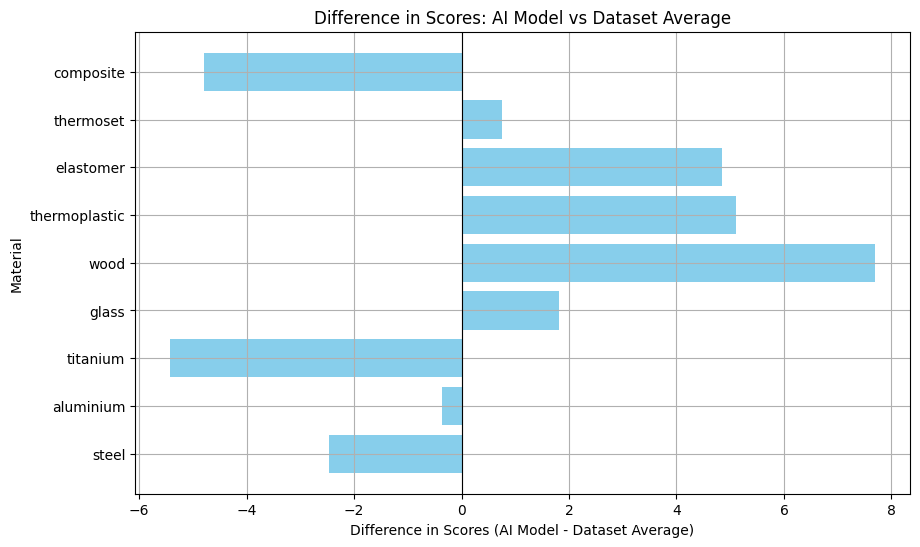

In [19]:
# Average scores from the dataset (as calculated earlier)
dataset_averages = {
    "steel": 5.46,
    "aluminium": 5.37,
    "titanium": 7.42,
    "glass": 4.19,
    "wood": 1.31,
    "thermoplastic": 2.89,
    "elastomer": 2.16,
    "thermoset": 3.25,
    "composite": 5.80
}

# AI model's scores from the JSON file
file_path = "./data/json_files/Spacecraft Component_Resistant to Heat.json"
with open(file_path, 'r') as json_file:
    ai_scores = json.load(json_file)
    ai_scores = json.loads(ai_scores)

# Difference between AI model scores and dataset averages
materials = list(dataset_averages.keys())
differences = []
for material in materials:
    ai_score = ai_scores.get(material, 0)
    dataset_avg = dataset_averages[material]
    differences.append(ai_score - dataset_avg)


plt.figure(figsize=(10, 6))
plt.barh(materials, differences, color='skyblue')
plt.xlabel('Difference in Scores (AI Model - Dataset Average)')
plt.ylabel('Material')
plt.title('Difference in Scores: AI Model vs Dataset Average')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True)
plt.show()


# Example for Kitchen Utensil Grip + Lightweight

In [20]:
file_path = "./data/json_files/Kitchen Utensil Grip_Lightweight.json"

with open(file_path, 'r') as json_file:
    rank_data = json.load(json_file)
    print(rank_data)
    print(type(rank_data))

    dict_r = json.loads(rank_data)
    print(dict_r)
    print(type(dict_r))

{
    "design": "Kitchen Utensil Grip",
    "criterion": "Lightweight",
    "steel": 9,
    "aluminium": 4,
    "titanium": 5,
    "glass": 8,
    "wood": 6,
    "thermoplastic": 1,
    "elastomer": 2,
    "thermoset": 3,
    "composite": 7
}
<class 'str'>
{'design': 'Kitchen Utensil Grip', 'criterion': 'Lightweight', 'steel': 9, 'aluminium': 4, 'titanium': 5, 'glass': 8, 'wood': 6, 'thermoplastic': 1, 'elastomer': 2, 'thermoset': 3, 'composite': 7}
<class 'dict'>


In [21]:
q1_columns = [col for col in dataset_clean_pd.columns if col.startswith('Q1_')]

q1_averages = dataset_clean_pd[q1_columns].mean()

q1_averages

,0
Q1_Steel,2.955224
Q1_Aluminium,6.119403
Q1_Titanium,5.134328
Q1_Glass,2.194030
Q1_Wood,6.134328
Q1_Thermoplastic,5.492537
Q1_Elastomer,4.701493
Q1_Thermoset,5.791045
Q1_Composite,6.970149


In [22]:
file_path = "./data/json_files/Kitchen Utensil Grip_Lightweight.json"

with open(file_path, 'r') as json_file:
    rank_data = json.load(json_file)

    rank_data = json.loads(rank_data)

design = rank_data.get('design', 'N/A')
criterion = rank_data.get('criterion', 'N/A')
material_scores = {key: value for key, value in rank_data.items() if key not in ['design', 'criterion']}

print(f"Design: {design}")
print(f"Criterion: {criterion}")
print("Material Scores:")
for material, score in material_scores.items():
    print(f"{material}: {score}")


Design: Kitchen Utensil Grip
Criterion: Lightweight
Material Scores:
steel: 9
aluminium: 4
titanium: 5
glass: 8
wood: 6
thermoplastic: 1
elastomer: 2
thermoset: 3
composite: 7


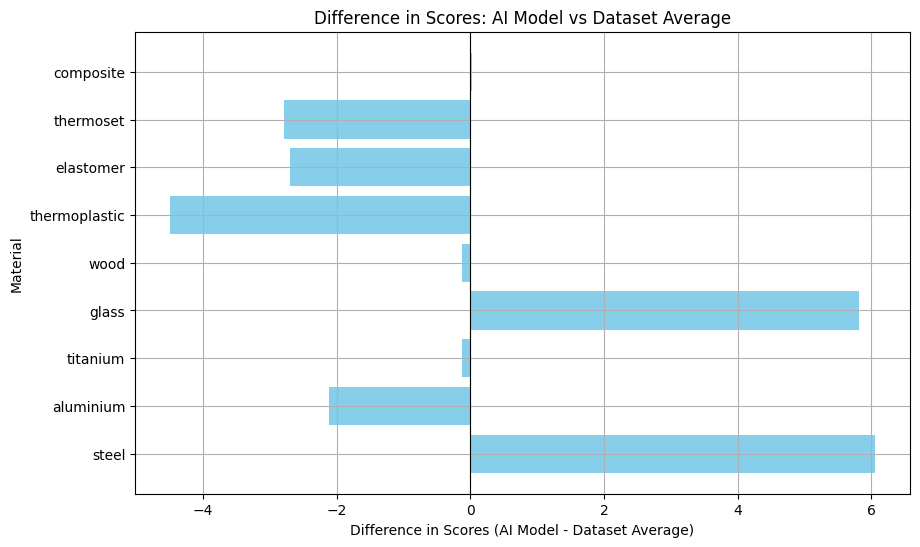

In [23]:
dataset_averages = {
    "steel": 2.95,
    "aluminium": 6.12,
    "titanium": 5.13,
    "glass": 2.19,
    "wood": 6.13,
    "thermoplastic": 5.49,
    "elastomer": 4.70,
    "thermoset": 5.79,
    "composite": 6.97
}

# AI model's scores from the JSON file
file_path = "./data/json_files/Kitchen Utensil Grip_Lightweight.json"
with open(file_path, 'r') as json_file:
    ai_scores = json.load(json_file)
    ai_scores = json.loads(ai_scores)

# Difference between AI model scores and dataset averages
materials = list(dataset_averages.keys())
differences = []
for material in materials:
    ai_score = ai_scores.get(material, 0)
    dataset_avg = dataset_averages[material]
    differences.append(ai_score - dataset_avg)


plt.figure(figsize=(10, 6))
plt.barh(materials, differences, color='skyblue')
plt.xlabel('Difference in Scores (AI Model - Dataset Average)')
plt.ylabel('Material')
plt.title('Difference in Scores: AI Model vs Dataset Average')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True)
plt.show()

# Example for Underwater Component + Corrosion Resistant

In [24]:
file_path = "./data/json_files/Underwater Component_Corrosion Resistant.json"

with open(file_path, 'r') as json_file:
    rank_data = json.load(json_file)
    print(rank_data)
    print(type(rank_data))

    dict_r = json.loads(rank_data)
    print(dict_r)
    print(type(dict_r))

{
    "design": "Underwater Component",
    "criterion": "Corrosion Resistant",
    "steel": 7,
    "aluminium": 5,
    "titanium": 1,
    "glass": 6,
    "wood": 9,
    "thermoplastic": 3,
    "elastomer": 4,
    "thermoset": 2,
    "composite": 8
}
<class 'str'>
{'design': 'Underwater Component', 'criterion': 'Corrosion Resistant', 'steel': 7, 'aluminium': 5, 'titanium': 1, 'glass': 6, 'wood': 9, 'thermoplastic': 3, 'elastomer': 4, 'thermoset': 2, 'composite': 8}
<class 'dict'>


In [25]:
q11_columns = [col for col in dataset_clean_pd.columns if col.startswith('Q11_')]

q11_averages = dataset_clean_pd[q11_columns].mean()

q11_averages

,0
Q11_Steel,3.940299
Q11_Aluminium,6.373134
Q11_Titanium,8.119403
Q11_Glass,6.029851
Q11_Wood,2.641791
Q11_Thermoplastic,5.507463
Q11_Elastomer,4.507463
Q11_Thermoset,5.283582
Q11_Composite,7.268657


In [26]:
file_path = "./data/json_files/Underwater Component_Corrosion Resistant.json"

with open(file_path, 'r') as json_file:
    rank_data = json.load(json_file)

    rank_data = json.loads(rank_data)

design = rank_data.get('design', 'N/A')
criterion = rank_data.get('criterion', 'N/A')
material_scores = {key: value for key, value in rank_data.items() if key not in ['design', 'criterion']}

print(f"Design: {design}")
print(f"Criterion: {criterion}")
print("Material Scores:")
for material, score in material_scores.items():
    print(f"{material}: {score}")


Design: Underwater Component
Criterion: Corrosion Resistant
Material Scores:
steel: 7
aluminium: 5
titanium: 1
glass: 6
wood: 9
thermoplastic: 3
elastomer: 4
thermoset: 2
composite: 8


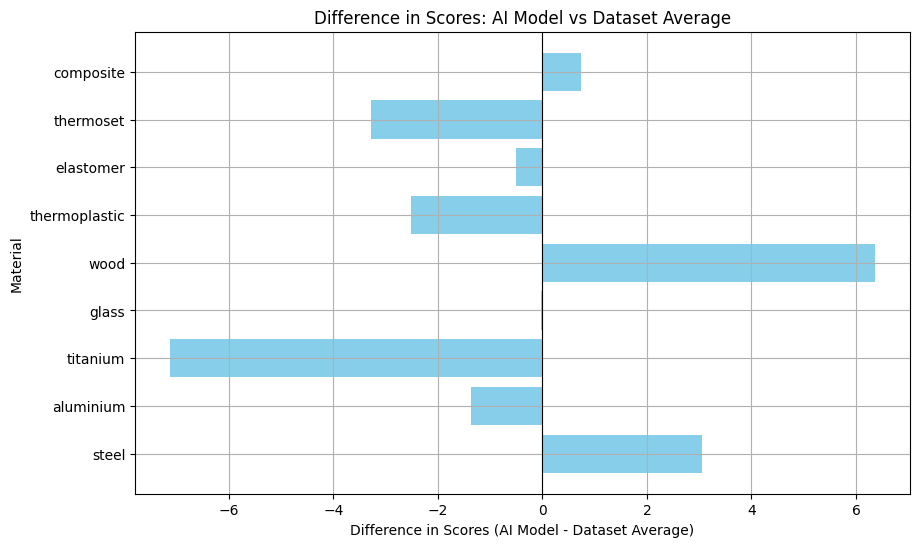

In [27]:
dataset_averages = {
    "steel": 3.94,
    "aluminium": 6.37,
    "titanium": 8.12,
    "glass": 6.03,
    "wood": 2.64,
    "thermoplastic": 5.51,
    "elastomer": 4.51,
    "thermoset": 5.28,
    "composite": 7.27
}

# AI model's scores from the JSON file
file_path = "./data/json_files/Underwater Component_Corrosion Resistant.json"
with open(file_path, 'r') as json_file:
    ai_scores = json.load(json_file)
    ai_scores = json.loads(ai_scores)

# Difference between AI model scores and dataset averages
materials = list(dataset_averages.keys())
differences = []
for material in materials:
    ai_score = ai_scores.get(material, 0)
    dataset_avg = dataset_averages[material]
    differences.append(ai_score - dataset_avg)


plt.figure(figsize=(10, 6))
plt.barh(materials, differences, color='skyblue')
plt.xlabel('Difference in Scores (AI Model - Dataset Average)')
plt.ylabel('Material')
plt.title('Difference in Scores: AI Model vs Dataset Average')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True)
plt.show()

# Example for Safety Helmet + High Strength

In [28]:
file_path = "./data/json_files/Safety Helmet_High Strength.json"

with open(file_path, 'r') as json_file:
    rank_data = json.load(json_file)
    print(rank_data)
    print(type(rank_data))

    dict_r = json.loads(rank_data)
    print(dict_r)
    print(type(dict_r))

{
    "design": "Safety Helmet",
    "criterion": "High Strength",
    "steel": 1,
    "aluminium": 4,
    "titanium": 2,
    "glass": 8,
    "wood": 9,
    "thermoplastic": 5,
    "elastomer": 7,
    "thermoset": 6,
    "composite": 3
}
<class 'str'>
{'design': 'Safety Helmet', 'criterion': 'High Strength', 'steel': 1, 'aluminium': 4, 'titanium': 2, 'glass': 8, 'wood': 9, 'thermoplastic': 5, 'elastomer': 7, 'thermoset': 6, 'composite': 3}
<class 'dict'>


In [29]:
q16_columns = [col for col in dataset_clean_pd.columns if col.startswith('Q16_')]

q16_averages = dataset_clean_pd[q16_columns].mean()

q16_averages

,0
Q16_Steel,5.910448
Q16_Aluminium,5.955224
Q16_Titanium,7.134328
Q16_Glass,1.597015
Q16_Wood,2.507463
Q16_Thermoplastic,5.089552
Q16_Elastomer,3.283582
Q16_Thermoset,4.835821
Q16_Composite,8.388060


In [30]:
file_path = "./data/json_files/Safety Helmet_High Strength.json"

# Load the JSON file
with open(file_path, 'r') as json_file:
    rank_data = json.load(json_file)

    rank_data = json.loads(rank_data)

# Extract the scores
design = rank_data.get('design', 'N/A')
criterion = rank_data.get('criterion', 'N/A')
material_scores = {key: value for key, value in rank_data.items() if key not in ['design', 'criterion']}

# Display the extracted information
print(f"Design: {design}")
print(f"Criterion: {criterion}")
print("Material Scores:")
for material, score in material_scores.items():
    print(f"{material}: {score}")


Design: Safety Helmet
Criterion: High Strength
Material Scores:
steel: 1
aluminium: 4
titanium: 2
glass: 8
wood: 9
thermoplastic: 5
elastomer: 7
thermoset: 6
composite: 3


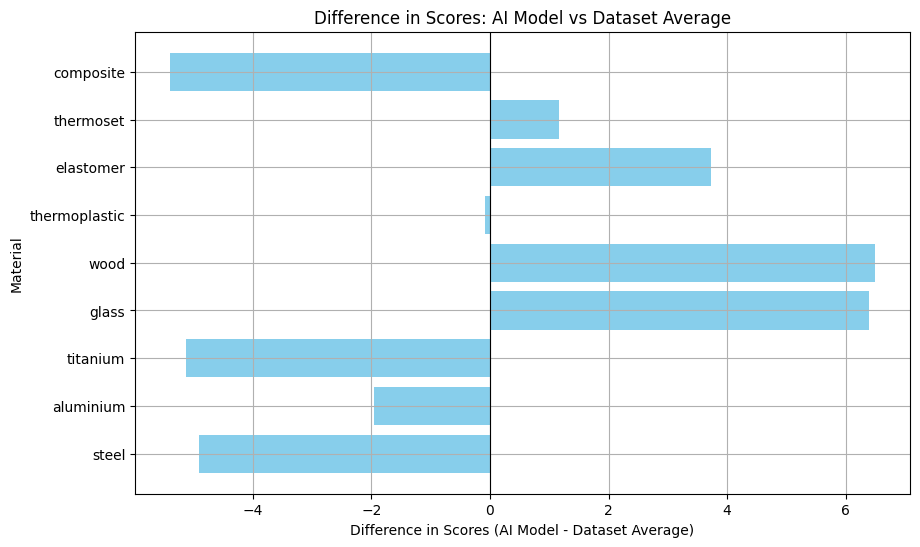

In [31]:
dataset_averages = {
    "steel": 5.91,
    "aluminium": 5.95,
    "titanium": 7.13,
    "glass": 1.60,
    "wood": 2.51,
    "thermoplastic": 5.09,
    "elastomer": 3.28,
    "thermoset": 4.84,
    "composite": 8.39
}

# AI model's scores from the JSON file
file_path = "./data/json_files/Safety Helmet_High Strength.json"
with open(file_path, 'r') as json_file:
    ai_scores = json.load(json_file)
    ai_scores = json.loads(ai_scores)

# Difference between AI model scores and dataset averages
materials = list(dataset_averages.keys())
differences = []
for material in materials:
    ai_score = ai_scores.get(material, 0)
    dataset_avg = dataset_averages[material]
    differences.append(ai_score - dataset_avg)


plt.figure(figsize=(10, 6))
plt.barh(materials, differences, color='skyblue')
plt.xlabel('Difference in Scores (AI Model - Dataset Average)')
plt.ylabel('Material')
plt.title('Difference in Scores: AI Model vs Dataset Average')
plt.axvline(0, color='black', linewidth=0.8)
plt.grid(True)
plt.show()